<a href="https://colab.research.google.com/github/65-1157/Aplica-o_NLP_gera-o_textos/blob/main/5123_KNN_Instrumentos_Musicais_Feature_Importance_Grid_Search_Andr%C3%A9_Marques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1_Preparação_ferramentas



Importação_bibliotecas





In [1]:
import numpy as np
import itertools
import pandas as pd
# System
import os, fnmatch
# visualização
import seaborn as sn
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display
# Aprendizado_máquina
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
# Dados_aleatórios
from numpy.random import seed
seed(1)
# biblioteca_audio
import librosa.display, librosa

In [2]:
# gerenciamento_alarmes
import warnings
warnings.filterwarnings('ignore')

2_Dataset_Detalhes_Gerais

Arquivo_dataset_Phillarmonica

In [3]:
!git clone https://github.com/GuitarsAI/BasicsMusicalInstrumClassifi
!unzip ./BasicsMusicalInstrumClassifi/audio/*.zip -d ./BasicsMusicalInstrumClassifi/audio
path="./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# pegar_audios
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("encontrados %d audio_arquivos: %s"%(len(files),path))

Cloning into 'BasicsMusicalInstrumClassifi'...
remote: Enumerating objects: 904, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 904 (delta 3), reused 0 (delta 0), pack-reused 895
Receiving objects: 100% (904/904), 14.10 MiB | 21.27 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Archive:  ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi.zip
   creating: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/
  inflating: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/mfcc_feature_vectors.pl  
 extracting: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/max_length.pl  
   creating: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/
  inflating: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_Ds3_05_fortissimo_arco-normal.mp3  
  inflating: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_A

Carregar_nomes

In [4]:
# Carregamento_identificação
labels =[]
classes=['flute','sax','oboe', 'cello','trumpet','viola']
color_dict={'cello':'blue', 'flute':'red', 'oboe':'green', 'trumpet':'black', 'sax':'magenta', 'viola':'yellow'}
color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

Atribuir_rótulos_labels

In [5]:
# Alocação_labels_encoders
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

6 classes: cello, flute, oboe, sax, trumpet, viola


Parâmetros_processamento

In [53]:
# Parâmetros
fs = 44100         # frequência_amostragem
n_fft = 2048       # janela_FFT_será_alterado
hop_length = 512   # Hop_será_alterado
n_mels = 128       # MEL bands_inalterado
n_mfcc = 13        # MFCCs_inalterado

# Geral_Aprendizado_Máquina
testset_size = 0.25 # Limite_corte_teste_treino
n_neighbors=1       # qte_vizinhos_será_alterado

Funções_cálculo

In [54]:
# Cálculo: MFCC 
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    #feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector

In [55]:
# Operação_dados_cálculo_features_feature vectors
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print ("colhido %d de %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() # normalização pelo valor máximo (razão_será_<1)
        if len(y) < 2:
            print("Erro_carregamento %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Erro_carregamento %s. Error: %s" % (f,e))
        
print("Cálculos %d feature_vectors"%len(feature_vectors))

colhido 1 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Gs4_025_forte_normal.mp3
colhido 2 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Ds4_05_pianissimo_subtone.mp3
colhido 3 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Gs4_1_pianissimo_normal.mp3
colhido 4 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_A4_1_mezzo-forte_normal.mp3
colhido 5 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Gs3_05_fortissimo_normal.mp3
colhido 6 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_A5_15_pianissimo_normal.mp3
colhido 7 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Gs3_05_pianissimo_normal.mp3
colhido 8 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Ds4_05_mezzo-forte_normal.m

In [56]:
# Alteração_dados_com_StandardScaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Formato_feature_vectors:",scaled_feature_vectors.shape)

Formato_feature_vectors: (600, 13)


In [57]:
df=pd.DataFrame(scaled_feature_vectors)

In [58]:
df.head(2) #exibição dos 13 MFCCs

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1.519038,-0.678997,-0.326567,0.006179,-0.387926,-1.004894,-0.795711,-1.561185,-1.159038,-1.110052,-1.145505,-1.227391,-1.253762
1,-0.103317,-0.383091,0.585574,2.426633,1.892038,0.072974,0.362021,0.417603,0.625797,-0.292882,-0.825797,-1.104103,-0.717101


In [59]:
df1=pd.DataFrame(classes_num)
df1.head(2)

,0
0,3
1,3


Data_Frame_Análise_Exploratória_junção_dois_arrays

In [60]:
df2=pd.concat([df,df1],axis=1)
df2.tail(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,0
598,1.007961,1.394728,1.083120,0.619847,0.384149,0.979673,-0.316191,-0.864540,-0.948105,-0.026869,-0.779471,-1.494069,-2.017028,0
599,0.827283,-0.359658,0.615691,0.967333,-0.410019,-0.156191,-0.847044,-1.315184,0.496700,1.343055,1.521363,1.346261,0.085716,0


In [61]:
df2.columns=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','classe']

Separação_treino_teste

In [62]:
# Divisão_treino_teste: trocada a cada simulação
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [63]:
# Confirmação_formatos_shapes: confirmado a cada simulação
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (450, 13)
test_set shape: (150, 13)
train_classes shape: (450,)
test_classes shape: (150,)


Classicador_KNN

In [64]:
# Definição_KNN_model
n_neighbors= 5
model_knn = KNeighborsClassifier(n_neighbors=n_neighbors)

In [65]:
# Ajuste_KNN
model_knn.fit(train_set,train_classes);

Analise_feature_importance

MFCC_feature:0 Score:0.011111111111111072
MFCC_feature:1 Score:0.015111111111111098
MFCC_feature:2 Score:0.01733333333333329
MFCC_feature:3 Score:0.028444444444444404
MFCC_feature:4 Score:0.039111111111111076
MFCC_feature:5 Score:0.04488888888888887
MFCC_feature:6 Score:0.04666666666666661
MFCC_feature:7 Score:0.04711111111111108
MFCC_feature:8 Score:0.059555555555555494
MFCC_feature:9 Score:0.06488888888888886
MFCC_feature:10 Score:0.06933333333333332
MFCC_feature:11 Score:0.09511111111111108
MFCC_feature:12 Score:0.13244444444444442


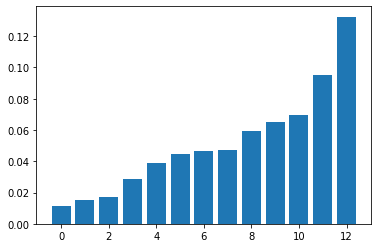

In [ ]:
# permutation_importance
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
res = permutation_importance(model_knn,train_set,train_classes, scoring='accuracy')
imp = res.importances_mean
imp = np.sort(imp)
for i,v in enumerate(imp):
  print('MFCC_feature:{} Score:{}' .format(i,v))
pyplot.bar([x for x in range(len(imp))], imp)
pyplot.show()

Predição

In [ ]:
# Aplicação_modelo_desenvolvido
predicted_labels = model_knn.predict(pca_test)

Métricas

In [ ]:
# Recall - identificação_todos_positivos
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))
# Precision - identificação_discernimento_positivo_negativo
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))
# F1-Score - ponderação_recall_precision
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))
# Accuracy - quantidade_previsões_certas
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Número_amostras:",test_classes.shape[0])

Recall:  [0.36 0.24 0.16 0.52 0.04 0.24]
Precision:  [0.28125    0.21428571 0.13793103 1.         0.04545455 0.23076923]
F1-Score:  [0.31578947 0.22641509 0.14814815 0.68421053 0.04255319 0.23529412]
Accuracy: 0.26  , 39
Número_amostras: 150


Grid_Search

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

k_range = list(range(1,50)) # lista de variação do k
param_grid = dict(n_neighbors=k_range) # dicinário sobre a variação
grid = GridSearchCV(model_knn, param_grid, cv=10, scoring='accuracy') # aplicação com métrica F1_score
grid.fit(train_set, train_classes) # alvo no setor de treino


GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [33]:
grid.cv_results_

{'mean_fit_time': array([0.00095251, 0.00070069, 0.00066421, 0.00070066, 0.00066004,
        0.00065243, 0.00067382, 0.00062099, 0.0006501 , 0.00069752,
        0.00066583, 0.00073116, 0.00066271, 0.00068521, 0.00062444,
        0.00060372, 0.00060709, 0.00061004, 0.00068343, 0.00062547,
        0.00068185, 0.00062058, 0.00064273, 0.00062027, 0.00064101,
        0.00061519, 0.00066719, 0.00070767, 0.00069327, 0.00063095,
        0.00065382, 0.00059643, 0.0009156 , 0.00065372, 0.00063729,
        0.00063751, 0.00064104, 0.00064082, 0.00068672, 0.00065384,
        0.00065765, 0.00064912, 0.0006475 , 0.00063739, 0.00067298,
        0.00064027, 0.00066292, 0.00066562, 0.00078614]),
 'mean_score_time': array([0.0028573 , 0.00228231, 0.00228496, 0.00233104, 0.00224793,
        0.00225863, 0.00280006, 0.00225983, 0.00245697, 0.00250876,
        0.00251801, 0.00246696, 0.00246258, 0.0023    , 0.00255947,
        0.0022717 , 0.0022723 , 0.00226007, 0.002618  , 0.00237691,
        0.00271945, 0.

In [66]:
# Setup arrays para armazenar acuracia de treinamento e teste
treino_accuracy = np.empty(len(k_range))
teste_accuracy = np.empty(len(k_range))
# Loop para os K vizinhos
for i, k in enumerate(k_range):
    # Iniciar o classificador knn
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fazer o fit na base de treinamento
    knn.fit(train_set,train_classes)
    
    # Calcular acuracia na base de treinamento
    treino_accuracy[i] = knn.score(train_set,train_classes)
    # Calcular acuracia na base de teste
    teste_accuracy[i] = knn.score(test_set, test_classes)


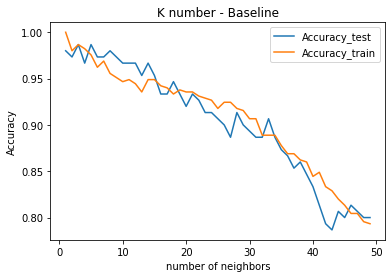

In [67]:
plt.title('K number - Baseline')
plt.plot(k_range, teste_accuracy, label = 'Accuracy_test')
plt.plot(k_range, treino_accuracy, label = 'Accuracy_train')
plt.legend()
plt.xlabel('number of neighbors')
plt.ylabel('Accuracy')
plt.show()

Matriz de Confusão

In [ ]:
# Execução_Matriz_Confusão
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

Plotagem_Matriz

In [ ]:
# Plotagem_Matriz_Confusão
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("matriz_confusão_normalizada")
    else:
        print('matriz_confusão_não_normalizada')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')

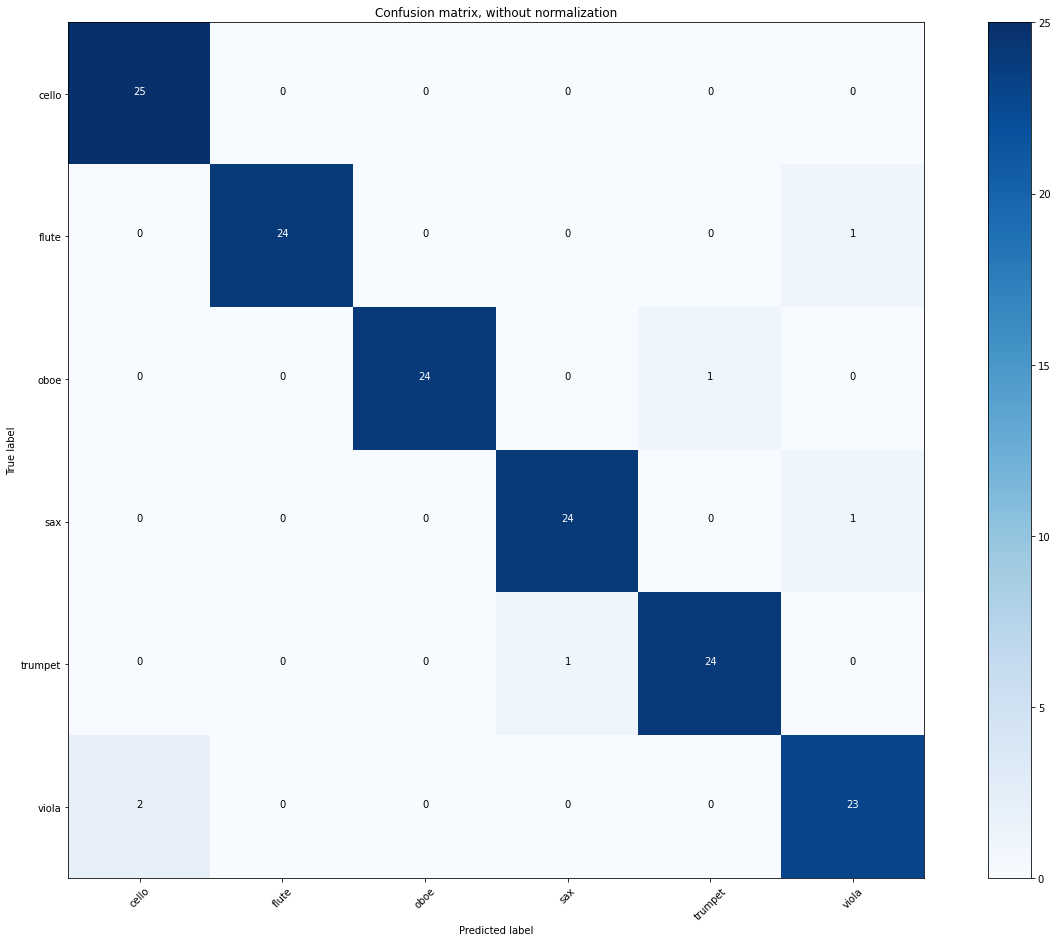

In [ ]:
# MC_não_normalizada
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='matriz_confusão_sem_normalização')

Valores_preditos_erroneamente

In [ ]:
# Exemplos_preditos_incorretamente
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [ ]:
# Predições_incorretas
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

['sax' 'sax' 'viola' 'oboe' 'oboe' 'cello' 'sax' 'sax' 'viola' 'viola'
 'cello']
[4 5 4 4 4 5 5 4 0 0 5]
['trumpet' 'viola' 'trumpet' 'trumpet' 'trumpet' 'viola' 'viola' 'trumpet'
 'cello' 'cello' 'viola']
['./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Ds5_1_forte_minor-trill.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Ds4_05_pianissimo_subtone.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_Gs5_1_fortissimo_snap-pizz.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/oboe/oboe_As3_15_mezzo-forte_normal.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/oboe/oboe_As3_1_mezzo-forte_normal.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/cello/cello_A4_1_mezzo-forte_arco-harmonic.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Gs3_05_pianissimo_normal.mp3'
 './BasicsMusicalInstrumCla